In [ ]:
# elasticNet
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

# SMOTE
# https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html

# Bayesian Survival Analysis
# https://pymc-devs.github.io/pymc3/notebooks/survival_analysis.html

# xgboost
# https://github.com/dmlc/xgboost
# https://www.youtube.com/watch?v=ufHo8vbk6g4

# hyperopt



In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib notebook
%matplotlib inline 
plt.style.use('seaborn-bright')

import pickle
from IPython.display import display

from sklearn import linear_model
from sklearn import metrics

%load_ext memory_profiler
%load_ext line_profiler

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 50)

pd.set_option('display.max_columns', 0)

%load_ext autoreload
%autoreload

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
height has been deprecated.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def train_test_split(dataX, datay, proportion_train = .75):
    train_cutoff = int(np.floor(proportion_train*len(dataX)))

    X_train = dataX[:train_cutoff]
    X_test  = dataX[train_cutoff:]

    y_train = datay[:train_cutoff]
    y_test  = datay[train_cutoff:]

    return X_train, y_train, X_test, y_test

def feature_target_split(df,feature_names, target_name):
    X_data = df[feature_names].as_matrix()
    y_data = df[target_name].as_matrix()
    return X_data, y_data

In [256]:
# custom scorer for scoring cv
X_train = [[20,10,1],[22,11,2],[33,13,3],[-20,-10,1],[-22,-11,2],[-33,-13,3]] # pattern: z=1,2,3 is labeled -1,0,1 respectively
y_train = [-1,0,1,-1,0,1]

scorer = metrics.make_scorer(metrics.accuracy_score, sample_weight=[0.5])

model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

def my_scorer(model,X, y_true):
    y_pred = model.predict(X)

    temp_weight = y_true
    ind = y_true == 0
    temp_weight[ind] = 0
    temp_weight[~ind] = 1 # weight want to be integers

    return metrics.accuracy_score(y_true, y_pred, sample_weight=temp_weight )

print scorer(model,[[1,2,3]],[1]) # same interface as this
my_scorer(model,[[1,2,3]],[1]) 

1.0


1.0

[[ 8.89154705  9.12653569]]
[-2.20536491]


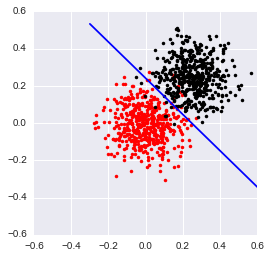

In [258]:
# plotting the decision boundary of logistic regression
np.random.seed(0)
mu, sigma = 0, 0.1 # mean and standard deviation
x0 = np.random.normal(mu, sigma, 500)
y0 = np.random.normal(mu, sigma, 500)

df1 = pd.DataFrame({'x':x0, 'y':y0, 'label':0})

mu, sigma = 0.25, 0.1 # mean and standard deviation
x1 = np.random.normal(mu, sigma, 500)
y1 = np.random.normal(mu, sigma, 500)

df2 = pd.DataFrame({'x':x1, 'y':y1, 'label':1})

df = pd.concat([df1,df2])
df
######
X_data, y_data = feature_target_split(df,['x','y'],'label')
model = linear_model.LogisticRegression()
model.fit(X_data,y_data)
print model.coef_
print model.intercept_

plt.plot(x0,y0,'r.')
plt.plot(x1,y1,'k.')

m = - model.coef_[0][0] / model.coef_[0][1]
c = - model.intercept_[0] / model.coef_[0][1]

xx = np.linspace(-.3, .7)
yy = m * xx + c

plt.plot(xx, yy, 'b-')
plt.xlim(-.6, .6)
plt.ylim(-.6, .6)
plt.gca().set_aspect('equal', adjustable='box')

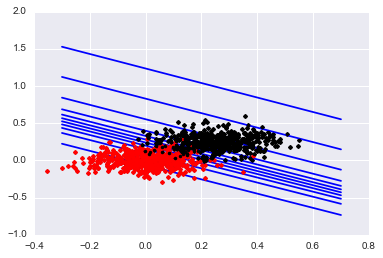

In [90]:
# how does the class weight affect the decision boundary in logistic regression

mu, sigma = 0, 0.1 # mean and standard deviation
x0 = np.random.normal(mu, sigma, 500)
y0 = np.random.normal(mu, sigma, 500)

df1 = pd.DataFrame({'x':x0, 'y':y0, 'label':0})

mu, sigma = 0.25, 0.1 # mean and standard deviation
x1 = np.random.normal(mu, sigma, 500)
y1 = np.random.normal(mu, sigma, 500)

df2 = pd.DataFrame({'x':x1, 'y':y1, 'label':1})

df = pd.concat([df1,df2])
df
######
X_data, y_data = feature_target_split(df,['x','y'],'label')

for cw in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97]:
    cw1=cw
    cw2=1-cw
    model = linear_model.LogisticRegression(class_weight={0:cw1, 1:cw2})
    model.fit(X_data,y_data)
#     print model.coef_
#     print model.intercept_

    plt.plot(x0,y0,'r.')
    plt.plot(x1,y1,'k.')

    m = - model.coef_[0][0] / model.coef_[0][1]
    c = - model.intercept_[0] / model.coef_[0][1]

    xx = np.linspace(-.3, .7)
    yy = m * xx + c

    plt.plot(xx, yy, 'b-')



[[ -6.45856968 -11.98762638]
 [ 13.17380288   0.01621012]
 [ -7.26241424  11.5109297 ]]
[ 2.02479877 -2.19953246 -3.61686435]


(-0.6, 0.6)

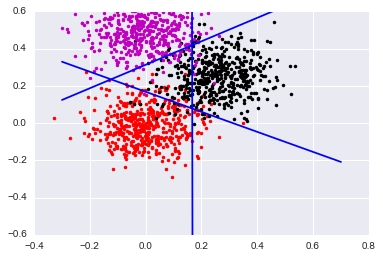

In [162]:
# decision boundary in multi class logistic regression 
mu, sigma = 0, 0.1 # mean and standard deviation
x0 = np.random.normal(mu, sigma, 500)
y0 = np.random.normal(mu, sigma, 500)

df1 = pd.DataFrame({'x':x0, 'y':y0, 'label':-1})

mu, sigma = 0.25, 0.1 # mean and standard deviation
x1 = np.random.normal(mu, sigma, 500)
y1 = np.random.normal(mu, sigma, 500)
df2 = pd.DataFrame({'x':x1, 'y':y1, 'label':0})

mu, sigma = 0.5, 0.1 # mean and standard deviation
x2 = np.random.normal(0, sigma, 500)
y2 = np.random.normal(mu, sigma, 500)

df3 = pd.DataFrame({'x':x2, 'y':y2, 'label':1})

df = pd.concat([df1, df2, df3])
df

######
X_data, y_data = feature_target_split(df,['x','y'],'label')
model = linear_model.LogisticRegression()
model.fit(X_data,y_data)
print model.coef_
print model.intercept_

plt.plot(x0,y0,'r.')
plt.plot(x1,y1,'k.')
plt.plot(x2,y2,'m.')

for i in range(3):
    m = - model.coef_[i][0] / model.coef_[i][1]
    c = - model.intercept_[i] / model.coef_[i][1]

    xx = np.linspace(-.3, .7)
    yy = m * xx + c

    plt.plot(xx, yy, 'b-')

plt.ylim((-.6,.6))



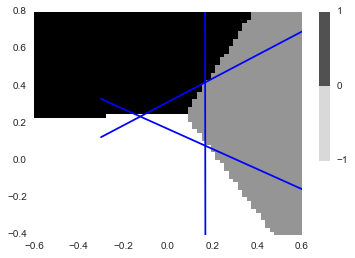

In [163]:
# using decision boundary to predict the class
nxxx, nyyy = (60, 60)
xxx = np.linspace(-.6, .6, nxxx)
yyy = np.linspace(-.4, .8, nyyy)
xxx_mesh, yyy_mesh = np.meshgrid(xxx, yyy)

result = np.zeros((nxxx, nyyy))
for i in range(len(xxx_mesh)):
    for j in range(len(yyy_mesh)):
      result[i][j] = model.predict([[xxx_mesh[i][j], yyy_mesh[i][j]]])[0]
#         print [xxx_mesh[i][j], yyy_mesh[i][j]]



plt.pcolor(xxx_mesh, yyy_mesh, result)

for i in range(3):
    m = - model.coef_[i][0] / model.coef_[i][1]
    c = - model.intercept_[i] / model.coef_[i][1]

    xx = np.linspace(-.3, .7)
    yy = m * xx + c

    plt.plot(xx, yy, 'b-')

plt.xlim((-.6,.6))
plt.ylim((-.4,.8))
plt.colorbar(boundaries=[-2,-1,0,1], ticks=[-1,0,1])

array([[  5.40556558e-01,   4.59436632e-01,   6.81004431e-06]])

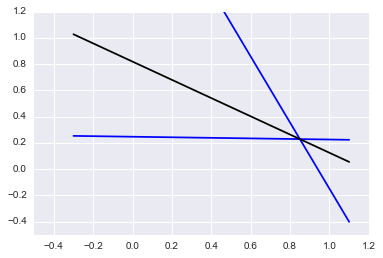

In [253]:
# calculating the bisector line, given two lines

coef = np.array([[ -0.25191655, -11.85789168],
 [  5.81548604,   2.30902321]])



intercept =[ 2.92869131, -5.470203]
a1 = coef[0][0]
b1 = coef[0][1]
c1 = intercept[0]
a2 = coef[1][0]
b2 = coef[1][1]
c2 = intercept[1]


for i in range(2):
    m = - coef[i][0] / coef[i][1]
    c = - intercept[i] / coef[i][1]

    xx = np.linspace(-.3, 1.1)
    yy = m * xx + c

    plt.plot(xx, yy, 'b-')

# # bisecting line
# b_xcoef = np.sum(coef[0,:])
# b_ycoef = np.sum(coef[1,:])
# # b_xcoef = np.sum(coef[:,0])
# # b_ycoef = np.sum(coef[:,1])
# b_intercept= - np.sum(intercept)
# print [b_xcoef, b_ycoef, b_intercept]

# m = - b_xcoef /b_ycoef
# c = - b_intercept /b_ycoef
# xx = np.linspace(-.3, .7)
# yy = m * xx + c

# plt.plot(xx, yy, 'k-')

A = ( a1/np.sqrt(a1**2+b1**2) - a2/np.sqrt(a2**2+b2**2))
B = ( b1/np.sqrt(a1**2+b1**2) - b2/np.sqrt(a2**2+b2**2))
C = ( c1/np.sqrt(a1**2+b1**2) - c2/np.sqrt(a2**2+b2**2))

m = - A / B
c = - C / B

xx = np.linspace(-.3, 1.1)
yy = m * xx + c

plt.plot(xx, yy, 'k-')

plt.xlim((-0.5,1.2))
plt.ylim((-0.5,1.2))

m*(1)+c
model.predict_proba([[1, 0.12456506304944326]])